In [41]:
%matplotlib inline
from Utils.config import generalConfig, structDqnConfig, model_dir
import numpy as np
np.random.seed(generalConfig["global_seed"])
from keras.models import Graph
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Dropout, Activation, Masking
from keras.layers.embeddings import Embedding
from keras.optimizers import RMSprop
from keras.layers.core import TimeDistributedMerge, TimeDistributedDense
from keras.layers import containers
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pickle as pkl
from sklearn.neighbors import NearestNeighbors

In [2]:
graph = Graph()
graph.add_input(name='usr', input_shape=(None, 5415))
graph.add_input(name='sys', input_shape=(None, 36))
graph.add_input(name='cmp', input_shape=(None, 1))

sys_embed = 10
usr_embed = 30

graph.add_node(TimeDistributedDense(sys_embed, input_dim=36), name="sys_embed", input="sys")
graph.add_node(TimeDistributedDense(usr_embed, input_dim=5415), name="usr_embed", input="usr")
embed_size = sys_embed + usr_embed + 1
loss = {}

shared_model = containers.Sequential()
shared_model.add(Masking(mask_value=0.0, input_shape=(None, embed_size)))
shared_model.add(LSTM(256, input_dim=embed_size, return_sequences=False))
shared_model.add(Dropout(0.3))

graph.add_node(shared_model, name="recurrent_layers", inputs=["sys_embed", "usr_embed", "cmp"], merge_mode='concat')

# policies
policy_action_num = {"verbal":32, "computer": 3}

for p_name in ["verbal", "computer"]:
    graph.add_node(Dense(structDqnConfig["l1-"+p_name], activation='tanh'), name="l1-"+p_name, input="recurrent_layers")
    graph.add_node(Dropout(0.3), name="l1dp-"+p_name, input="l1-"+p_name)
    graph.add_node(Dense(policy_action_num[p_name], activation='linear'), name=p_name, input='l1dp-'+p_name, create_output=True)
    loss[p_name] = "mse"

opt = RMSprop(clipvalue=1.0)
graph.compile(optimizer=opt, loss=loss)

In [3]:
print graph.summary()

--------------------------------------------------------------------------------
Layer (name)                  Output Shape                  Param #             
--------------------------------------------------------------------------------
Layer (usr)                   (None, None, 5415)            0                   
Layer (sys)                   (None, None, 36)              0                   
Layer (cmp)                   (None, None, 1)               0                   
TimeDistributedDense (sys_embe(None, None, 10)              370                 
TimeDistributedDense (usr_embe(None, None, 30)              162480              
Sequential (recurrent_layers) (None, 256)                   305152              
Dense (l1-verbal)             (None, 128)                   32896               
Dropout (l1dp-verbal)         (None, 128)                   0                   
Dense (verbal)                (None, 32)                    4128                
Dense (l1-computer)         

In [11]:
graph.load_weights('Models/v2/test0/110000-lstm-struct.h5')

In [12]:
sys_w = graph.nodes['sys_embed'].get_weights()
usr_w = graph.nodes['usr_embed'].get_weights()

## Plot sys action embedding

In [13]:
all_sys = np.matrix(np.eye(36))
questions = pkl.load(open('Data/action_data.p'))['questions']

In [95]:
actions =  ['eos'] + [category for (category, utt) in questions] + ['inform'] + ['unknown', 'yes', 'no']
actions_utts =  ['eos'] + [category+'-'+utt for (category, utt) in questions] + ['inform'] + ['unknown', 'yes', 'no']
print actions
print len(actions)

['eos', u'gender', u'gender', u'birthplace', u'birthplace', u'birthplace', u'birthplace', u'birthplace', u'birthplace', u'birthplace', u'birthplace', u'birthplace', u'nationality', u'nationality', u'nationality', u'nationality', u'nationality', u'degree', u'degree', u'degree', u'degree', u'profession', u'profession', u'profession', u'profession', u'profession', u'profession', u'profession', u'profession', u'birthday', u'birthday', u'birthday', 'inform', 'unknown', 'yes', 'no']
36


In [15]:
sys_embed = all_sys * np.matrix(sys_w[0]) + sys_w[1]

In [138]:
tnse_model = TSNE(n_components=2, random_state=0, metric='euclidean')
pca_model = PCA(n_components=2)

In [21]:
def scatter_label(data, labels, color=None):
    N = data.shape[0]
    if color is None:
        color = [str(item*(255/N)/255.) for item in range(N)]
    plt.subplots_adjust(bottom = 0.1)
    plt.scatter(data[:, 0], data[:, 1], c=color, cmap = plt.get_cmap('Spectral'))
    
    # add label if neccssary
    if labels is not None:
        cnt = 0
        for label, x, y in zip(labels, data[:, 0], data[:, 1]):
            if cnt % 2 == 0:
                plt.annotate(label, xy = (x, y), xytext = (-20, 20),
                    textcoords = 'offset points', ha = 'right', va = 'bottom',
                    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
                    arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
            else:
                plt.annotate(label, xy = (x, y), xytext = (-20, 20),
                    textcoords = 'offset points', ha = 'right', va = 'bottom',
                    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
                    arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
            cnt += 1
    plt.show()

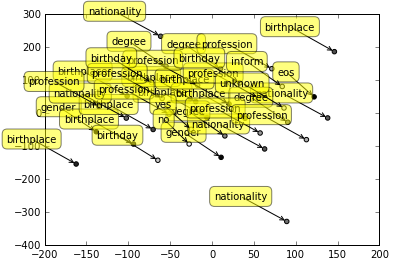

In [22]:
sys_tsne = tnse_model.fit_transform(sys_embed) 
scatter_label(sys_tsne, actions)

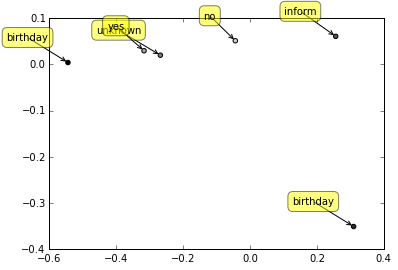

In [76]:
sys_pca = pca_model.fit_transform(sys_embed)
scatter_label(sys_pca[30:], actions[30:])

In [137]:
neigh = NearestNeighbors(n_neighbors=5, algorithm='brute', metric='cosine')
neigh.fit(sys_embed)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='euclidean',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [126]:
nn = 20
(dist, idx) = neigh.kneighbors(sys_embed[34:], nn)
for i in range(nn):
    print (actions_utts[idx[0, i]] , dist[0, i])


('yes', 2.2204460492503131e-16)
(u'nationality-Is this person a citizen of a country in Asia?', 0.084742754059105696)
(u'degree-Does this person have degree before college?', 0.090256575849351317)
(u'birthday-Is this person born before 1950s?', 0.14550676714112842)
('unknown', 0.14959758396922551)
(u'birthplace-Is this person born in middle east?', 0.15348410767729026)
(u'degree-Does this person have bachelor degree?', 0.16063362120464264)
(u'birthplace-Is this person born in south America?', 0.17668648806875442)
(u'birthplace-Is this person born in west europe?', 0.18234810786142808)
(u'profession-Is this persson related to sports?', 0.19979483743723037)
(u'nationality-Is this person a citizen of a country in Europe?', 0.22443335457162061)
(u'nationality-Is this person a citizen of Australia?', 0.23978922505300093)
(u'degree-Does this person have master degree?', 0.2613583873786971)
(u'birthday-Is this person born before 1930s?', 0.26335684659526926)
('eos', 0.28041014742519299)
('no'

## Plot user response

In [25]:
bigram_resp = pkl.load(open('Data/bigram_usr_resp.pkl', 'rb'))

In [131]:
yes_embed = bigram_resp["yes"] * usr_w[0] + usr_w[1]
no_embed = bigram_resp["no"] * usr_w[0] + usr_w[1]
unknown_embed = bigram_resp["unknown"] * usr_w[0] + usr_w[1] 
cor_embed = bigram_resp["correct"] * usr_w[0] + usr_w[1] 
wrong_embed = bigram_resp["wrong"] * usr_w[0] + usr_w[1] 

all_embed = np.vstack([yes_embed, no_embed, unknown_embed, cor_embed, wrong_embed])
dialogActs = ['b'] * yes_embed.shape[0] + ['y'] * no_embed.shape[0] + ['r'] * unknown_embed.shape[0]\
+ ['g'] * cor_embed.shape[0] + ['c'] * wrong_embed.shape[0]

In [139]:
usr_tsne = tnse_model.fit_transform(all_embed) 

In [ ]:
scatter_label(usr_tsne, labels=None, color=dialogActs)

In [29]:
usr_pca = pca_model.fit_transform(all_embed)

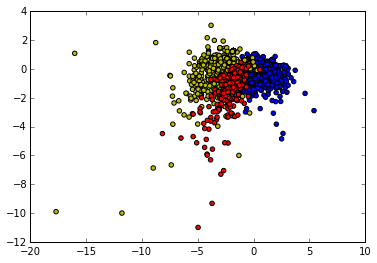

In [30]:
scatter_label(usr_pca, labels=None, color=dialogActs)